# Segmentation of Indian Traffic

In [4]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import tensorflow as tf
# tf.enable_eager_execution()
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
# from hilbert import hilbertCurve
import imgaug.augmenters as iaa
import numpy as np
# import albumentations as A
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten,BatchNormalization, ReLU, Reshape
#from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, CuDNNLSTM, BatchNormalization, ReLU, Reshape
from tensorflow.keras.models import Model
import random as rn

<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [ ]:
def return_file_names_df(root_dir):
  paths = [list(),list()]
  data_files = os.listdir(root_dir)
  for i,sub_file in enumerate(data_files):
    sub_file_path = root_dir + '/' + sub_file + '/'
    folder = os.listdir(sub_file_path)
    for folder_name in folder:
      path_name_folder_name = root_dir + '/' + sub_file + '/' + folder_name + '/'
      files = os.listdir(path_name_folder_name)
      for file in files:
        if (file.endswith("jpg")):
          path_name = root_dir + '/' + sub_file + '/' + folder_name + '/' + file
          path_name = str(path_name)
          paths[i].append(path_name)

        if (file.endswith("json")):
          path_name = root_dir + '/' + sub_file + '/' + folder_name + '/' + file
          path_name = str(path_name)
          paths[i].append(path_name)

  # intialise data of lists. 
  data = {'image':paths[0], 
        'json':paths[1]} 
  
  # Create DataFrame 
  data_df = pd.DataFrame(data) 
       
  return data_df

In [ ]:
root_dir = 'data'
data_df = return_file_names_df(root_dir)
data_df.head()

,image,json
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json


In [ ]:
import json 
  
# Opening JSON file 
f = open('data/mask/201/frame0029_gtFine_polygons.json',) 
  
# returns JSON object as  
# a dictionary 
data = json.load(f) 
  
# Iterating through the json 
# list
labels = [] 
for i in data['objects']: 
  #print(i['label'])
  labels.append(i['label']) 

  
# Closing file 
f.close()

In [ ]:
print(len(list(set(labels))))

18


> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [ ]:

def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

In [ ]:
grader_1(data_df)

True

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [ ]:

def return_unique_labels(data_df):
  unique_labels = dict()
  for i , row in data_df.iterrows():
    # Opening JSON file 
    f = open(row['json'],) 
    data = json.load(f)
    labels = [] 
    for i in data['objects']:
      labels.append(i['label']) 

    labels = list(set(labels))  

    for label in labels:
      unique_labels[label] = unique_labels.get(label, 0) + 1
      #if label not in unique_labels:
        #unique_labels[label] += 1
  return unique_labels

In [ ]:
unique_labels = return_unique_labels(data_df)

In [ ]:
unique_labels

{'animal': 341,
 'autorickshaw': 2035,
 'bicycle': 321,
 'billboard': 2509,
 'bridge': 387,
 'building': 3136,
 'bus': 914,
 'car': 2981,
 'caravan': 53,
 'curb': 2447,
 'drivable fallback': 3616,
 'ego vehicle': 2,
 'fallback background': 893,
 'fence': 1024,
 'ground': 2,
 'guard rail': 728,
 'motorcycle': 2955,
 'non-drivable fallback': 2931,
 'obs-str-bar-fallback': 3972,
 'out of roi': 127,
 'parking': 17,
 'person': 2422,
 'pole': 3866,
 'polegroup': 337,
 'rail track': 4,
 'rectification border': 3,
 'rider': 2825,
 'road': 3861,
 'sidewalk': 617,
 'sky': 3991,
 'traffic light': 167,
 'traffic sign': 1728,
 'trailer': 6,
 'train': 4,
 'truck': 2090,
 'tunnel': 5,
 'unlabeled': 2,
 'vegetation': 3984,
 'vehicle fallback': 2459,
 'wall': 2180}

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [5]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [6]:
class_label = [i for i in label_clr.values()]
class_label = list(set(class_label))
class_label = sorted(class_label)
class_label

[0,
 10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200]

In [7]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(label_clr)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [ ]:
file = 'data/mask/201/frame0029_gtFine_polygons.json'
def get_poly(file):
  f = open(file,)
  data = json.load(f) 
  h = data['imgHeight']
  w = data['imgWidth']
  label = []
  vertexlist = []
  for i in data['objects']:
    label.append(i['label']) 
    polygon = i['polygon']
    polygon = [tuple(i) for i in polygon]
    vertexlist.append(polygon)


  return w, h, label, vertexlist  

In [ ]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

### Example

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

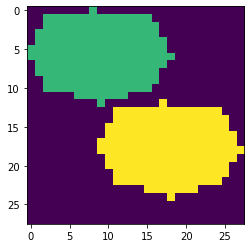

In [ ]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [ ]:
file = 'data/mask/201/frame0029_gtFine_polygons.json'
w, h, labels, vertexlist = get_poly(file)

In [ ]:
def compute_masks(data_df):
  mask = []
  for i , row in data_df.iterrows():
    file = row['json']
    file1 = row['image']
    w, h, labels, vertexlist = get_poly(file)

    s = file1
    s = s.split('/')
    s = [i.split('.') for i in s]
    
    path = s[0][0] + '/' + 'output' + '/' + s[2][0] + '/' +s[3][0] + '.jpg'
    path = str(path)

    img = Image.new("RGB", (w, h))
    img1 = ImageDraw.Draw(img)
    found = 0
    for i in range(len(vertexlist)):
      if len(vertexlist[i]) == 0:
        found = 1

    if found == 0:
      for i in range(len(vertexlist)):
        img1.polygon(vertexlist[i], fill = label_clr[labels[i]])
      img=np.array(img)
      im = Image.fromarray(img[:,:,0])
      mask.append(path)
      im.save(path)
    else:
      mask.append('Nan')

  data_df['mask'] = mask
    
  return data_df

In [ ]:
data_df = compute_masks(data_df)

In [ ]:
data_df.to_csv('preprocessed_data.csv', index=False)

In [ ]:
import matplotlib.pyplot as plt


True
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]


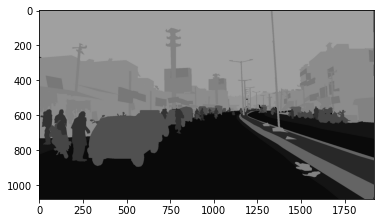

In [ ]:
# i  created two dataframe one with .png format and another with .jpg file because .png file is not 
# supported in further down data pipeline.
import urllib.request
def grader_3():
    url = "https://i.imgur.com/4XSUlHk.png"
    url_response = urllib.request.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
    my_img = cv2.imread('data4/output/201/frame0029_gtFine_polygons.png')    
    plt.imshow(my_img)
    print((my_img[:,:,0]==img).all())
    print(np.unique(img))
    print(np.unique(my_img[:,:,0]))
    data_df.to_csv('preprocessed_data.csv', index=False)
grader_3()

In [ ]:
import pandas as pd
df = pd.read_csv('preprocessed_data1.csv')

In [ ]:
d = df[(df['mask'] != 'Nan')]
d.shape


(4001, 3)

# Task 2: Applying Unet to segment the images

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this assignment we won't writingt this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1" 

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

</pre>

In [ ]:
file_name = []
for i , row in d.iterrows():
  f = []
  s = row['image']
  t = row['mask']
  #s = s.split('/')
  #s = [i.split('.') for i in s]
  f.append(s)
  f.append(t)
  file_name.append(f)



In [ ]:
len(file_name)

4001

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(list(file_name), test_size=0.15, random_state=42)

In [ ]:
!pip install -U --pre segmentation-models

     |████████████████████████████████| 51kB 4.3MB/s 


In [ ]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
from segmentation_models import Unet
sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [ ]:
# loading the unet model and using the resnet 34 and initilized weights with imagenet weights
# "classes" :different types of classes in the dataset
model = Unet('resnet34', encoder_weights='imagenet', classes=21, activation='softmax', encoder_freeze = True, input_shape=(512,512,3))

85524480/85521592 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 512, 512, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 256, 256, 64) 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [ ]:
import imgaug.augmenters as iaa
# For the assignment choose any 4 augumentation techniques
# check the imgaug documentations for more augmentations
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [ ]:
class Dataset:
    def __init__(self, file_names, classes , types):
        
        self.ids = file_names
        self.class_ids = classes
        self.types = types
        self.images_fps   = [image_id[0] for image_id in self.ids]
        self.masks_fps    = [image_id[1] for image_id in self.ids]
       

    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = np.float32(cv2.resize(image, (512, 512)))

        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        image_mask = mask
   

        image_masks = [(image_mask == i) for i  in self.class_ids]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
        image_mask = np.float32(cv2.resize(image_mask, (512, 512)))
        

        if self.types == 'train':
          a = np.random.uniform()
          if a<0.2:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
          elif a<0.4:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
          elif a<0.6:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(image_mask)
          elif a<0.8:
            image = aug5.augment_image(image)
            image_mask = image_mask
          else:
            image = aug6.augment_image(image)
            image_mask = aug6.augment_image(image_mask)

            
          return image, image_mask

        else:
          
          return image, image_mask

        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
# https://github.com/qubvel/segmentation_models
#import segmentation_models as sm
from segmentation_models.metrics import iou_score



rms = tf.keras.optimizers.RMSprop(learning_rate=0.001)

focal_loss = sm.losses.cce_dice_loss

model.compile(rms, focal_loss, metrics=[iou_score])

In [ ]:
#CLASSES = CLASSES
train_dataset = Dataset(X_train, classes=class_label , types ='train')
test_dataset  = Dataset(X_test, classes=class_label, types = 'test')

train_dataloader = Dataloder(train_dataset, batch_size=5, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=5, shuffle=True)

print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (5, 512, 512, 3)
assert train_dataloader[0][1].shape == (5, 512, 512, 21)

(5, 512, 512, 3)


In [ ]:
(train_dataloader[0][0].shape) , (train_dataloader[0][1].shape)

((5, 512, 512, 3), (5, 512, 512, 21))

In [ ]:
(test_dataloader[0][0].shape) , (test_dataloader[0][1].shape)

((5, 512, 512, 3), (5, 512, 512, 21))

In [ ]:
callbacks_ = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, \
                                       mode='min', monitor='val_iou_score')]

In [ ]:
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader)//5, epochs=70,\
                              validation_data=test_dataloader,validation_steps =len(test_dataloader)//5,callbacks=callbacks_ )


Epoch 1/70
136/136 [==============================] - 1277s 9s/step - loss: 0.9502 - iou_score: 0.0928 - val_loss: 1.0563 - val_iou_score: 0.0939
Epoch 2/70
136/136 [==============================] - 713s 5s/step - loss: 0.8116 - iou_score: 0.1841 - val_loss: 0.8965 - val_iou_score: 0.1386
Epoch 3/70
136/136 [==============================] - 625s 5s/step - loss: 0.7488 - iou_score: 0.2300 - val_loss: 0.8317 - val_iou_score: 0.1837
Epoch 4/70
136/136 [==============================] - 608s 4s/step - loss: 0.7204 - iou_score: 0.2569 - val_loss: 0.7799 - val_iou_score: 0.2259
Epoch 5/70
136/136 [==============================] - 568s 4s/step - loss: 0.6035 - iou_score: 0.3684 - val_loss: 0.5956 - val_iou_score: 0.3743
Epoch 6/70
136/136 [==============================] - 568s 4s/step - loss: 0.5926 - iou_score: 0.3792 - val_loss: 0.5894 - val_iou_score: 0.3812
Epoch 7/70
136/136 [==============================] - 517s 4s/step - loss: 0.5836 - iou_score: 0.3844 - val_loss: 0.5485 - val_io

### Task 2.1: Dice loss

<pre>
* Explain the Dice loss ?
ans :- Dice loss is the measure of overlap between the predict sample and the srue sample. suppose we have true sample pixel size of 512 * 512 and predict sample size of 512 * 512 , then dice loss function compare the each pixel from both of them. and calculate the average value which range   between 0 to 1. 0 define for there is no similarity between the true and predicted sample and 1 define both true and predicted sample are completely overlapping. 
  
* 1. Write the formualtion ?
ans :- Dice loss = 2*sum of (product of each pixel from true and predicted sample) from 1 to n divided by sum of square of true and predicted pixel from 1 to n where n is the number of pixel.

mathematicaly = 2 * ∑(tp * pp ) from 1 to n/(∑square(tp) + ∑square(pp)) from 1 to n.

* 2. Range of the loss function ?
ans :- it has the range   between 0 to 1.


* 3. Interpretation of loss function ?
ans:-  0 define for there is no similarity between the true and predicted sample and 1 define both true and predicted sample are completely overlapping.


* 4. Write your understanding of the loss function, how does it helps in segmentation ?
ans :-since we are predicting the pixel of image as an output. it is necessary that the each pixel from both true and predicted sample should match. As from the dice formula, denomirator defines the sum of square of each pixel from both true and predicted pixel and numerator define the overlap between both pixel. if particular pixel from each sample is similar then only it make sence othrwise it is zero. So if our model is giving 100% result numerator and denomirator cancel each other. In practicle world this metric is very essential as getting highest accuracy is very dificult to get.
</pre>

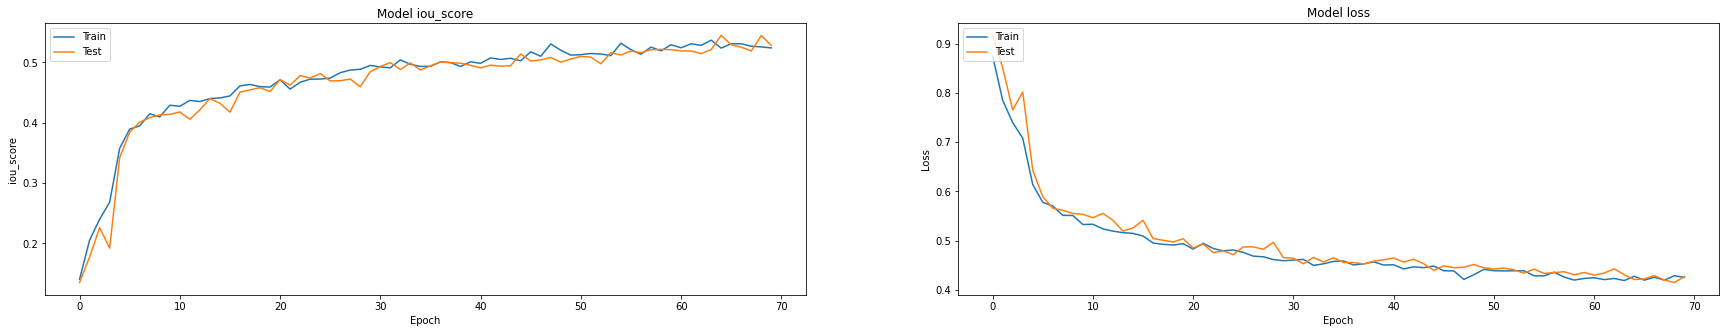

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

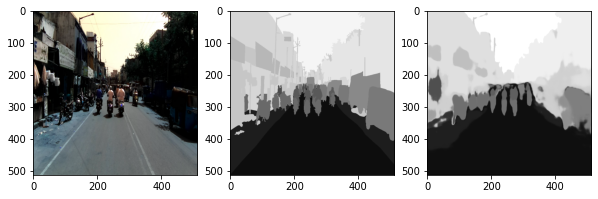

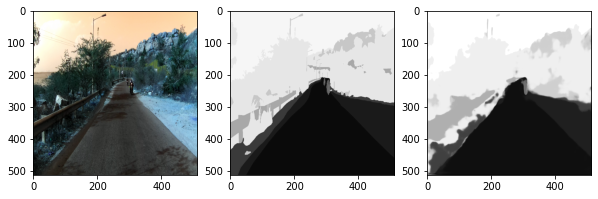

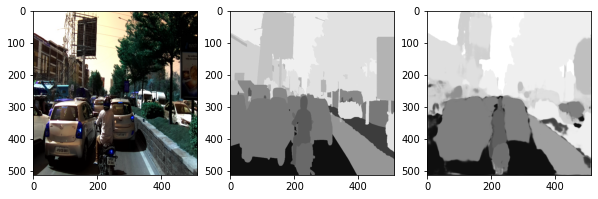

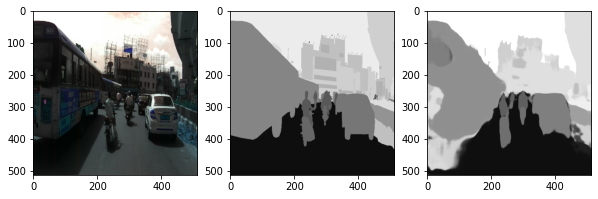

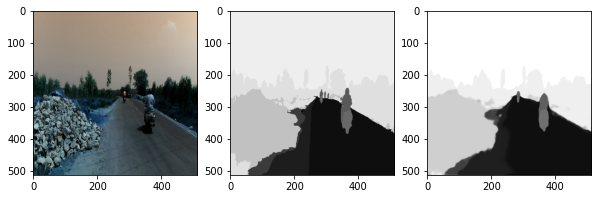

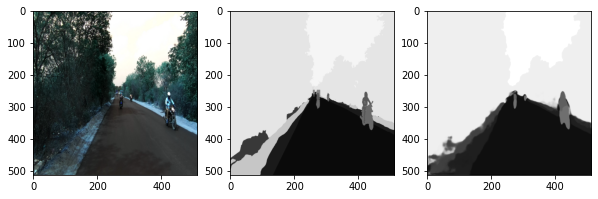

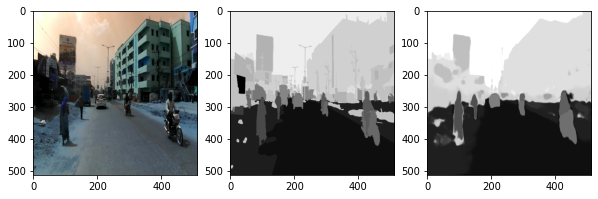

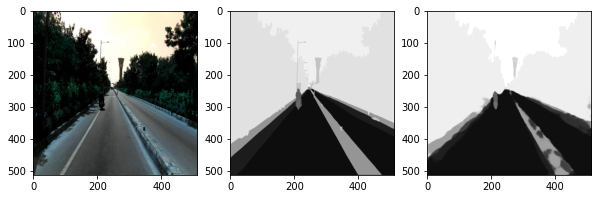

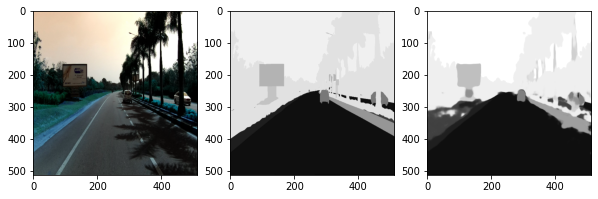

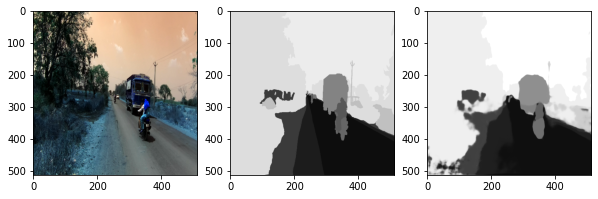

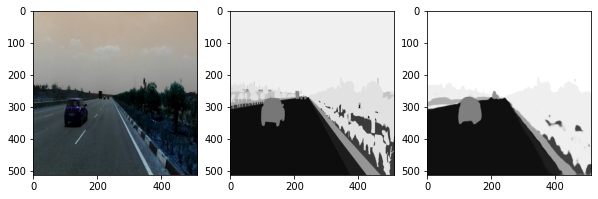

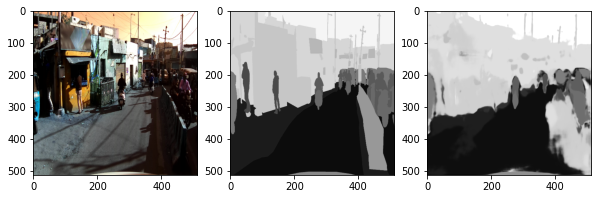

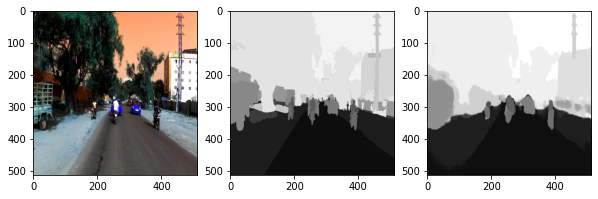

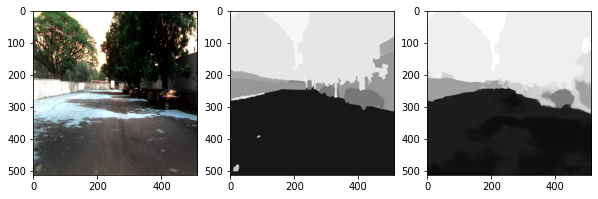

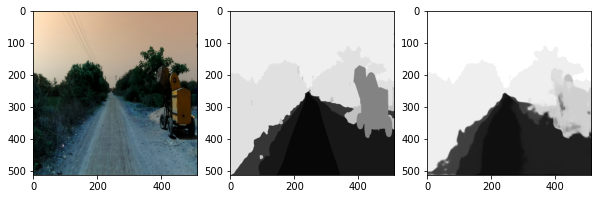

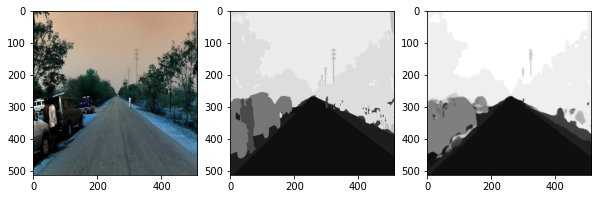

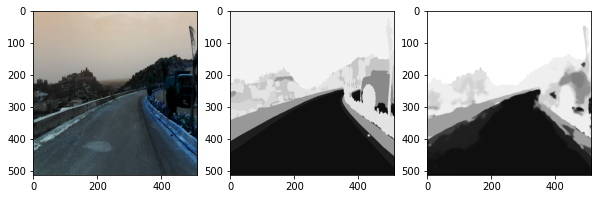

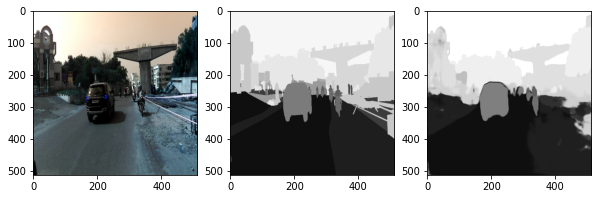

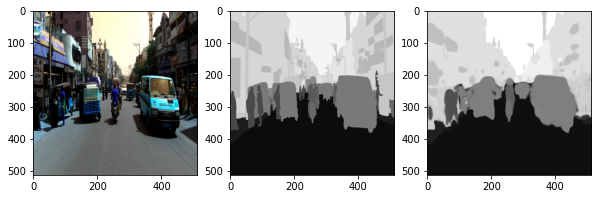

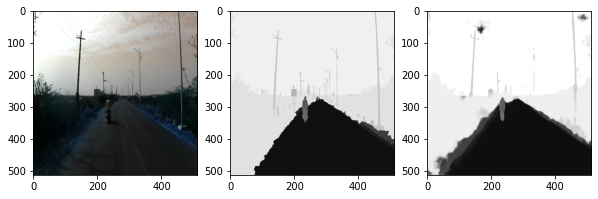

In [150]:
a = X_test
for i in range(20):  
    #original image
    image = cv2.imread(a[i][0],cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (512, 512))
    
    #predicted segmentation map
    predicted  = model.predict(image[np.newaxis,:,:,:])
    predict = np.array([predicted[0,:,:,i]*j for i , j in enumerate(class_label)])
    predict = sum(predict)
    
    #original segmentation map
    image_mask = cv2.imread(a[i][1], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (512,512))
    

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask, cmap='gray')
    plt.subplot(133)
    plt.imshow(predict, cmap='gray')
    plt.show()